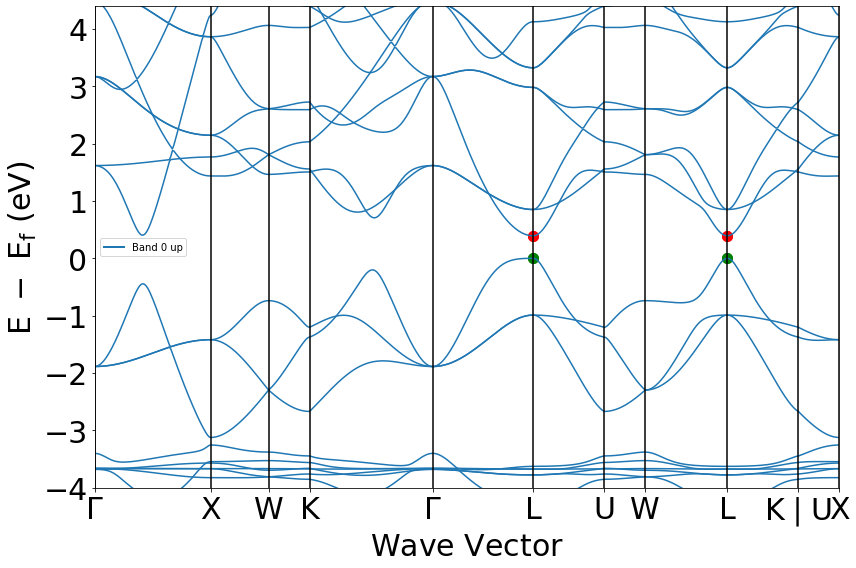

In [78]:
from pymatgen.ext.matproj import MPRester
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine
from pymatgen.electronic_structure.core import Spin
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.image as img

with MPRester("AchX5nmEpJI03g7B") as m:
    
    #Téléchargement de la structure de bandes
    bandstruct = m.get_bandstructure_by_material_id("mp-867193") 
    bsplot = BSPlotter(bandstruct)
    bsplot.get_plot(vbm_cbm_marker=True)


In [79]:
#BANDE INTERDITE

band_int = bandstruct.get_band_gap()
#print(band_int)
print("Energie de la bande interdite :", band_int["energy"], "eV","(donc la bande interdite se trouve entre 0 eV et",band_int["energy"], "eV)")
print("La bande interdite est", "directe" if  band_int["direct"] else "indirecte" )
print("Chemin de transition :", band_int['transition']) 

Energie de la bande interdite : 0.39139999999999997 eV (donc la bande interdite se trouve entre 0 eV et 0.39139999999999997 eV)
La bande interdite est directe
Chemin de transition : L-L


Nous avons bien une bande interdite directe car sur le graphe représentant les structures de bande, nous voyons qu les extremums des bandes de valence représentés par les points verts et ceux des bandes de conduction en rouge correspondent au même quasi-moment.

In [83]:
#Direction dans laquelle la dernière bande de valence/première bande de conduction présente le plus et le moins de dispersion 


data = bsplot.bs_plot_data()
distances = data.get('distances') 
energy = data.get('energy') 
dist = data.get('ticks').get('distance')

#Calcul de la pente
def pente(a,b):
    pente = (abs(a[-1] - a[0])) /(b[-1] - b[0])
    sol = [a[-1],a[0],b[-1],b[0],pente]
    return np.array(sol)

#Dispertion
def disp1(num):
    d = len(distances)
    pente_int = np.zeros((d,5))
    for i in range(d): # Calcul des pentes liées aux vecteurs k
        pente_int[i] = pente(energy["1"][i][num], distances[i])
    return(pente_int)

def disp2(pente_int):
    d = len(distances)
    inter = np.zeros(d)
    for i in range(d):
        inter[i] = pente_int[i][4]
    return(inter)
    

In [84]:
#DERNIERE BANDE DE VALENCE

vbm_band_index = bandstruct.get_vbm()['band_index'][Spin.up][0]
print("Indice de la dernière bande de valence : ", vbm_band_index)
print( "Il s\'agit de la bande de valence contenant l\'énergie maximale")

bval_max = np.argmax(disp1(vbm_band_index))
bval_min = np.argmin(disp1(vbm_band_index))

pente_bval_max = disp2(disp1(vbm_band_index))[bval_max]
pente_bval_min = disp2(disp1(vbm_band_index))[bval_min]


Indice de la dernière bande de valence :  17
Il s'agit de la bande de valence contenant l'énergie maximale


In [85]:
#PREMIERE BANDE DE CONDUCTION

cbm_band_index = bandstruct.get_cbm()['band_index'][Spin.up][0]
print("Indice de la première bande de conduction : ", cbm_band_index)
print("Il s\'agit de la bande de contenant contenant l\'énergie minimale")

bcond_max = np.argmax(disp1(cbm_band_index))
bcond_min = np.argmin(disp1(cbm_band_index))

pente_bcond_max = disp2(disp1(cbm_band_index))[bcond_max]
pente_bcond_min = disp2(disp1(cbm_band_index))[bcond_min]


Indice de la première bande de conduction :  18
Il s'agit de la bande de contenant contenant l'énergie minimale


[0.59697951 1.73782829 1.67659668 0.82319224 2.78194927 2.50845961
 1.67659668 1.33409141 2.50845961 0.78106367]


IndexError: index 47 is out of bounds for axis 0 with size 10

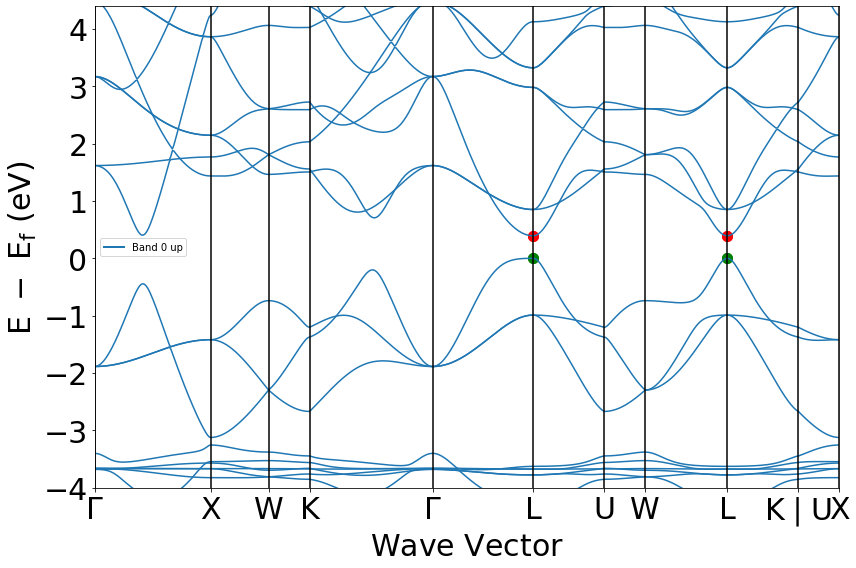

In [87]:
# AFFICHAGE DU GRAPHE 

bsplot.get_plot(vbm_cbm_marker=True)
print(disp2(disp1(vbm_band_index)))

plt.arrow(pente_bval_max[3],pente_bval_max[1],pente_bval_max[2]-pente_bval_max[3],pente_bval_max[0]-pente_bval_max[1],color='blue', width = 0.03,length_includes_head = True)
plt.arrow(pente_bval_min[3],pente_bval_min[1],pente_bval_min[2]-pente_bval_min[3],pente_bval_min[0]-pente_bval_min[1],color='green', width = 0.03,length_includes_head = True)
plt.arrow(pente_bcond_max[3],pente_bcond_max[1],pente_bcond_max[2]-pente_bcond_max[3],pente_bcond_max[0]-pente_bcond_max[1],color = 'red',width =0.03, length_includes_head = True)
plt.arrow(pente_bcond_min[3],pente_bcond_min[1],pente_bcond_min[2]-pente_bcond_min[3],pente_bcond_min[0]-pente_bcond_min[1],color = 'orange',width =0.03, length_includes_head = True)

plt.show()

print("La flèche bleue indique la pente maximale pour la bande de valence et celle-ci est égale à ", pente_bval_max[4])
print("La flèche verte indique la pente minimale pour la bande de valence et celle-ci est égale à ", pente_bval_min[4])
print("La flèche rouge indique la pente maximale pour la bande de conduction et celle-ci est égale à ", pente_bcond_max[4])
print("La flèche orange indique la pente minimale pour la bande de conduction et celle-ci est égale à ", pente_bcond_min[4])


In [90]:
#CALCUL DE LA MASSE EFFECTIVE 

h_bar = 6.5821e-16
m_electron = 9.11e-31

#1) AU SOMMET DE LA DERNIERE BANDE DE VALENCE 

vbm = bandstruct.get_vbm()
E_vbm = vbm['energy']
kp_vbm = vbm["kpoint"].cart_coords
kp_bval = vbm.get("kpoint").frac_coords
normk_bval = np.linalg.norm(kp_bval)

me_vbm = ((h_bar**2 * (kp_vbm[2]**2 + kp_vbm[1]**2 + kp_vbm[0]**2)) / (2*abs(E_vbm)))
print("La masse effective au sommet de la dernière bande de valence vaut ",me_vbm, "kg")


#2) A LA BASE DE LA PREMIERE BANDE DE CONDUCTION

cbm = bandstruct.get_cbm()
E_cbm = cbm['energy']
kp_cbm = cbm["kpoint"].cart_coords
kp_bcon = cbm.get("kpoint").frac_coords
normk_bcon = np.linalg.norm(kp_bcon)

me_cbm = ((h_bar**2 * (kp_cbm[2]**2 + kp_cbm[1]**2 + kp_cbm[0]**2)) / (2*(E_cbm)))
print("La masse effective à la base de la première bande de conduction vaut ", me_cbm, "kg")


La masse effective au sommet de la dernière bande de valence vaut  2.739930938555474e-32 kg
La masse effective à la base de la première bande de conduction vaut  2.473778264554876e-32 kg
